In [486]:
# Import packagaes

# Basic packages
import numpy as np
import copy
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

# To process fits file
from astropy.nddata import CCDData
from astropy.io import fits

# For numerical calculation
from astropy.stats import sigma_clipped_stats
from astropy.modeling import models, fitting

# For aperture photometry
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats

# for matching
from astropy.wcs import WCS
from astropy.coordinates import match_coordinates_sky

In [180]:
# Setting matplotlib parameters
# You don't need to change this cell unless you want to change plotting styles.

plt.rcParams["font.family"] = 'STIXGeneral'
plt.rcParams['text.usetex'] = False
plt.rcParams["mathtext.fontset"] = 'cm'
# plt.rcParams['figure.figsize']=[4,3.5]
plt.rcParams['font.size']=20
plt.rcParams['axes.linewidth']=1
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.major.size']=7
plt.rcParams['ytick.major.size']=7
plt.rcParams['xtick.minor.size']=3.5
plt.rcParams['ytick.minor.size']=3.5
plt.rcParams['xtick.major.width']=1
plt.rcParams['ytick.major.width']=1
plt.rcParams['xtick.minor.width']=1
plt.rcParams['ytick.minor.width']=1
plt.rcParams['ytick.right']=True
plt.rcParams['xtick.top']=True

# 1. Import images

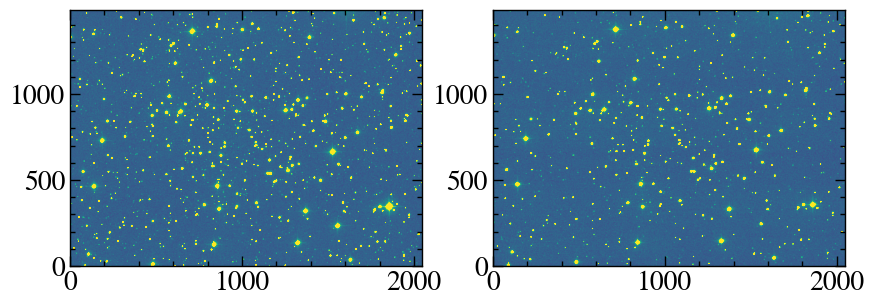

In [184]:
# Read fits data
rimage = CCDData.read('koposovo36_r.fits', hdu=0)
gimage = CCDData.read('koposovo36_g.fits', hdu=0)
# Save fits data in the list
data = [rimage, gimage]

# Plot the orginal image
# You may not need to change below
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
for i, dat in enumerate(data):
    scaler = ZScaleInterval()
    vmin, vmax = scaler.get_limits(dat)
    ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')

# 2. Detecting and centroiding stars

## 2.1. Masking

On the images, you see saturated stars. To correctly perfom photometry, it's better to mask the saturated stars.
Here, we set mask arrays that defines the area to be masked during photometry.
The defined mask arrays will be input to photutils.

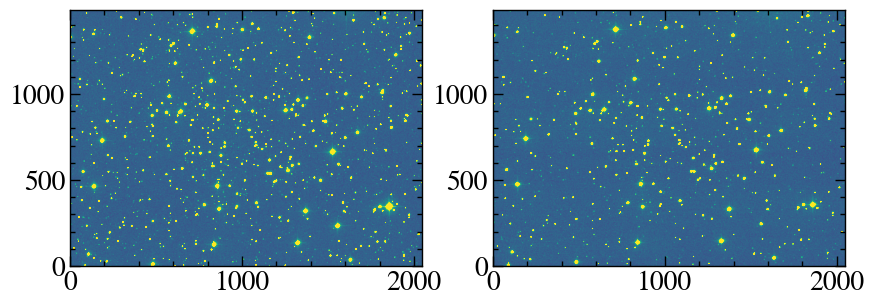

In [185]:
mask_f150w, mask_360m = np.zeros_like(data[0]).astype(bool), np.zeros_like(data[1]).astype(bool) # zero arrays with the same sizes of original images.

# Set values in the area you want to mask as Trues
# mask_f150w[350:600,0:100] = True
# mask_f150w[800:1000,1100:1400] = True
# mask_f150w[1400:1800,1100:1500] = True
# mask_f150w[200:260,1960:2020] = True
# mask_f150w[200:260,1960:2020] = True
# mask_f150w[650:700,0:50] = True

# mask_360m[0:150,750:1000] = True
# mask_360m[150:250,1030:1090] = True
# mask_360m[350:400,870:930] = True
# mask_360m[350:500,1600:1800] = True
# mask_360m[700:850,1600:1800] = True
# mask_360m[750:850,900:1020] = True


# Save the mask arrays in the list
mask = [mask_f150w, mask_360m]

# Plot the masked image
# You may not need to change below
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
for i, (dat, mas) in enumerate(zip(data, mask)):
    dat = copy.deepcopy(dat)
    scaler = ZScaleInterval()
    vmin, vmax = scaler.get_limits(dat)
    # dat.data[mas.astype(bool)] = 0
    ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')

## 2.2. Detetcing and centroiding the stars


 id      xcentroid      ...        flux                mag         
---- ------------------ ... ------------------ --------------------
   1 1248.7828508553573 ...  18.88663673400879  -3.1903865679243615
   2  659.4477817922423 ...   8.24199390411377  -2.2900807224470574
   3  792.7698754952203 ... 1.3259679079055786 -0.30633253266777455
 ...                ... ...                ...                  ...
1110 1270.2667747135563 ... 31.944705963134766   -3.760997237495663
1111   1474.09395224178 ... 2.4838926792144775  -0.9878320687051588
1112 1535.8811871842865 ...  1.299513339996338  -0.2844518551429092
Length = 1112 rows

 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  88.52935004865485 ... 362.81549072265625  -6.399214553410534
  2 1159.7059256418947 ... 3.5923402309417725  -1.388443655054398
  3  777.5305493195605 ...  3.481663227081299 -1.3544669013777204
...                ... ...           

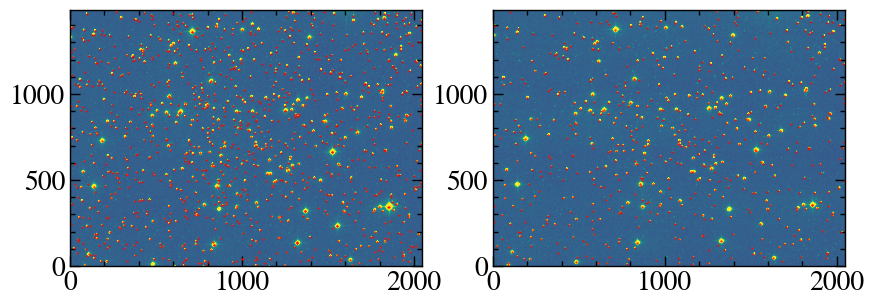

In [186]:
pos = [] # list to save the positions of detected stars in each image

# parameter settings
thres = 10 # pixel value above which, when multiplied by sigma, pixels are considered to be stars.
fwhm = 4 # minimum radius over which objects are considered to be stars.

for dat, mas in zip(data, mask):
    avg, med, std = sigma_clipped_stats(dat.data) # taking the statistics of the image with sigma clipping. Default clipping threshold is 3*sigma
    finder = DAOStarFinder(threshold=thres*std, fwhm=fwhm, exclude_border=True) # set a finder to detect a star
    sources = finder(dat.data - med, mask=mas) # detect stars. median is subtracted to minize the cotamination by the background
    print()
    sources.pprint(max_lines=10)
    pos.append(np.transpose((sources['xcentroid'], sources['ycentroid']))) # save the position of the stars

# Plot the detected stars
# You may not need to change it.
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
for i, (dat, mas) in enumerate(zip(data, mask)):
    dat = copy.deepcopy(dat)
    scaler = ZScaleInterval()
    vmin, vmax = scaler.get_limits(dat)
    # dat.data[mas.astype(bool)] = 0
    ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')
    ax[i].plot(pos[i][:,0], pos[i][:,1], 'ro', markersize=0.5)

# 3. Sum pixel values within the area of the stars

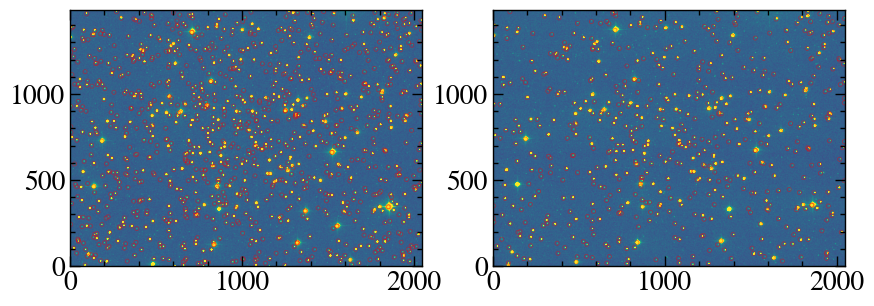

In [368]:
# Set apertures
apertures = [CircularAperture(pos[0], r=4*3), CircularAperture(pos[1], r=4*3)] # Here, we define the aperture with the radius of 4 times FWHM
sum_stars = [] # list to save the sum of pixel values of each star

for dat, aper in zip(data, apertures):
    starphot = ApertureStats(dat, aper) # take statistics of the pixel values within the area of the stars
    sum_stars.append(starphot.sum) # sum of the pixel values within the area of the stars
    
# Plot the detected stars
# You may not need to change it.
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
for i, (dat, mas, aper) in enumerate(zip(data, mask, apertures)):
    dat = copy.deepcopy(dat)
    scaler = ZScaleInterval()
    vmin, vmax = scaler.get_limits(dat)
    # dat.data[mas.astype(bool)] = 0
    ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')
    aper.plot(ax[i], color='r', alpha=0.5 ,lw=0.5)

# 4. sky annulus

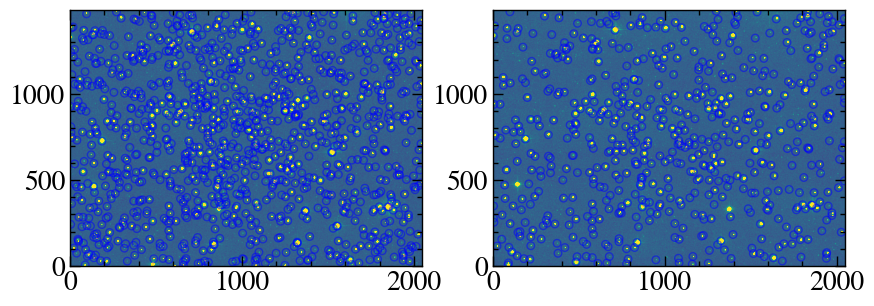

In [369]:
# Set annulus
annuluses = [CircularAnnulus(pos[0], r_in=4*5, r_out=4*6), CircularAnnulus(pos[1], r_in=4*5, r_out=4*6)] # Here, we define the aperture with the inner radius of 5 times FWHM and the outer radius of 6 times FWHM
mode_bkg = [] # list to save the mode of the background for each annulus

for dat, annul in zip(data, annuluses):
    bkgphot = ApertureStats(dat, annul) # take statistics of the pixel values within the annuluses
    mode_bkg.append(2.5*bkgphot.median-1.5*bkgphot.mean) # sum of the pixel values within the annuluses
    
# Plot the detected stars
# You may not need to change it.
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
for i, (dat, mas, annul) in enumerate(zip(data, mask, annuluses)):
    dat = copy.deepcopy(dat)
    scaler = ZScaleInterval()
    vmin, vmax = scaler.get_limits(dat)
    # dat.data[mas.astype(bool)] = 0
    ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')
    annul.plot(ax[i], color='b', alpha=0.5 ,lw=0.5)

# 5. Aperture photometry

In [370]:
fluxes = [] # list to save the net pixel values of each star
mags = [] # list to save the magnitudes of each star
for dat, mas, sum, bkg, aper in zip(data, mask, sum_stars, mode_bkg, apertures):
    flux = sum-aper.area_overlap(dat, mask=mas)*bkg # star - background
    mag = 22.5-2.5*np.log10(flux.value) # transfrom flux to magnitude
    fluxes.append(sum-aper.area_overlap(dat, mask=mas)*bkg)
    mags.append(mag)

/var/folders/tz/3b0hb0qd35gfvjpy9c1vqqfm0000gn/T/ipykernel_15620/2064802351.py:5: RuntimeWarning: invalid value encountered in log10
  mag = 22.5-2.5*np.log10(flux.value) # transfrom flux to magnitude


# 7. Matching

In [535]:
# You may not need to revise this

# convert pixel coordinates to ra, dec
coord = [WCS(fits.open('koposovo36_r.fits')[0].header).pixel_to_world(pos[0][:,0], pos[0][:,1]),
        WCS(fits.open('koposovo36_g.fits')[0].header).pixel_to_world(pos[1][:,0], pos[1][:,1])]
# matching
match_idx, match_angle,_ = match_coordinates_sky(coord[0], coord[1])

# construct a table with the columns of x_r, y_r, x_g, y_g, mag_r, mag_g
# In the table, only stars with mathcing_angle<1.5 arcsec (~seeing of SDSS)
rlim = 1.5
table=np.vstack([pos[0][:,0], pos[0][:,1], pos[1][match_idx,0], pos[1][match_idx,1],
                 coord[0].ra.value, coord[0].dec.value, coord[1].ra.value[match_idx], coord[1].dec.value[match_idx],
                 mags[0], mags[1][match_idx]]).T
table = table[match_angle.to_value('arcsec')<1.5,:]
table = pd.DataFrame(table, columns=['x_r', 'y_r', 'x_g', 'y_g', 'ra_r', 'dec_r', 'ra_g', 'dec_g', 'mag_r', 'mag_g'])

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [550]:
# matched table
table

,x_r,y_r,x_g,y_g,ra_r,dec_r,ra_g,dec_g,mag_r,mag_g
0,1248.782851,3.507142,1252.351952,15.285963,84.097787,31.193101,84.097786,31.193098,18.156043,19.582877
1,659.447782,4.701242,662.911377,16.646236,84.138697,31.138529,84.138698,31.138541,19.040868,20.932445
2,87.738983,5.584725,91.005886,17.417743,84.178309,31.085561,84.178288,31.085562,18.328615,16.426038
3,1079.400947,5.489902,1082.913203,17.443986,84.109727,31.177515,84.109743,31.177521,18.697421,19.973394
4,1679.156785,16.726569,1682.968322,28.404492,84.069409,31.233780,84.069398,31.233782,19.996716,20.878002
...,...,...,...,...,...,...,...,...,...,...
590,1409.706933,1462.194523,1413.468481,1474.005430,84.244876,31.294286,84.244873,31.294286,19.110202,20.262591
591,96.126350,1465.440462,99.587168,1477.483586,84.335969,31.172562,84.335958,31.172582,18.862541,20.144324
592,1532.512999,1464.862177,1536.362597,1476.613057,84.236671,31.305838,84.236660,31.305840,16.232652,17.185152
593,1825.599820,1464.892742,1829.489921,1476.642979,84.216391,31.333031,84.216389,31.333030,16.783001,17.530967


Text(0, 0.5, '$\\Delta\\mathrm{Dec.}$')

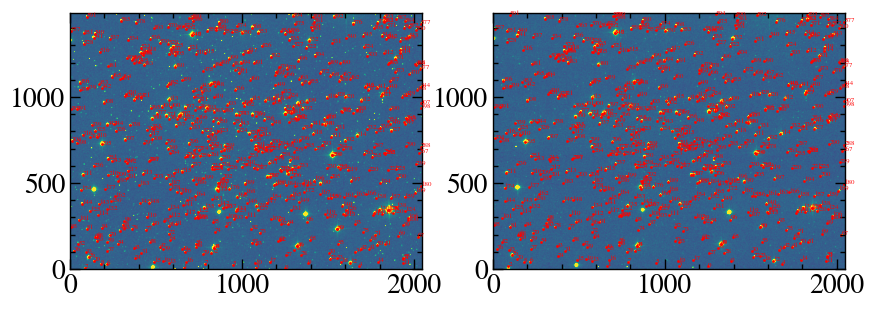

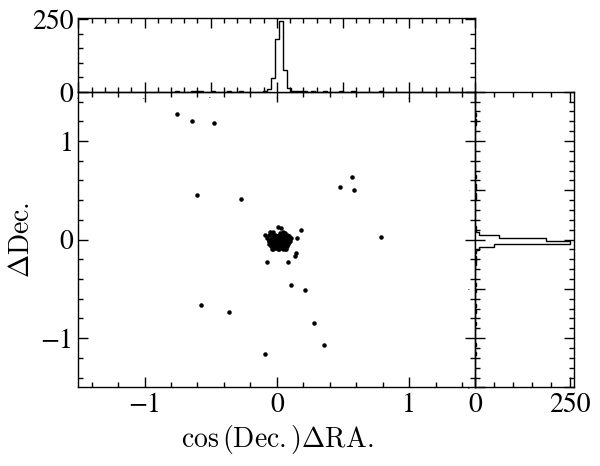

In [538]:
# Check if the mathching is done correctly
# If the matching is correct, the scatters center at (0,0)
# You may not need to revise it.

fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
for i, (dat, mas, annul) in enumerate(zip(data, mask, annuluses)):
    dat = copy.deepcopy(dat)
    scaler = ZScaleInterval()
    vmin, vmax = scaler.get_limits(dat)
    # dat.data[mas.astype(bool)] = 0
    ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')
ax[0].scatter(table['x_r'], table['y_r'], color='r', s=1)
for i in np.arange(len(table['x_r'])):
    ax[0].text(table['x_r'][i], table['y_r'][i], f'{i:d}', color='r', fontsize=5)
ax[1].scatter(table['x_g'], table['y_g'], color='r', s=1)
for i in np.arange(len(table['x_g'])):
    ax[1].text(table['x_g'][i], table['y_g'][i], f'{i:d}', color='r', fontsize=5)

fig = plt.figure()
fig.subplots_adjust(wspace=0, hspace=0)
gs = fig.add_gridspec(5,5)
point = fig.add_subplot(gs[1:,:4])
x_hist = fig.add_subplot(gs[0,:4])
x_hist.tick_params(axis='x', labelsize=0)
y_hist = fig.add_subplot(gs[1:,4])
y_hist.tick_params(axis='y', labelsize=0)

dra, ddec = (table['ra_r']-table['ra_g'])*3600*np.cos(np.median(table['dec_r']*np.pi/180)), (table['dec_r']-table['dec_g'])*3600 # difference of ra and dec in degree.
bins = np.linspace(-rlim,rlim,100)
point.scatter(dra, ddec, marker='o', color='k', s=5)
point.set_xlim(bins[0], bins[-1])
point.set_ylim(bins[0], bins[-1])

x_hist.hist(dra, bins=bins, color='k', histtype='step')
x_hist.set_xlim(bins[0], bins[-1])
y_hist.hist(ddec, bins=bins, color='k', histtype='step', orientation='horizontal')
y_hist.set_ylim(bins[0], bins[-1])

point.set_xlabel(r'$\cos{(\mathrm{Dec.})}\Delta\mathrm{RA.}$')
point.set_ylabel(r'$\Delta\mathrm{Dec.}$')

# 8. CMD

(22.0, 12.0)

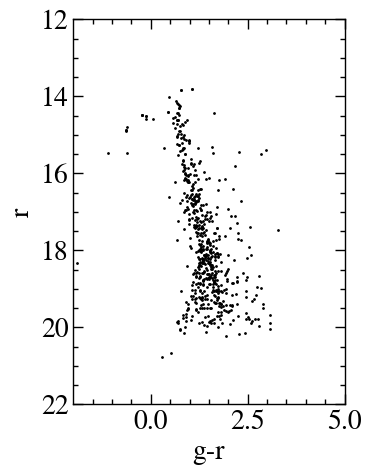

In [549]:
# plot CMD
# If you've run the above cells successfully, you don't need to revsie this (except for x, y ranges)
fig, ax = plt.subplots(1,1, figsize=(3.5,5))

ax.scatter(table['mag_g']-table['mag_r'], table['mag_r'], s=1, color='k')
ax.set_xlabel('g-r')
ax.set_ylabel('r')
ax.set_xlim(-2,5)
ax.set_ylim(22,12)